# AI-PBPK model project: hyperparameters tuning with BayesSearchCV
Author: Kun Mi
Date created: 2025/05/07

Description: In this study, we used ML and Deep nerual network models to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner
!pip install -q optuna

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/2-AI-PBPK"

# choose where you want your project files to be saved
project_folder = "/Final model/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-1.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
Ori,152
ID,0
Type,0
TS,0
MAT,0
Size,46
Zeta,71
Charge,66
Shape,0
TM,0


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta',"TSz",'Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)

q_high=df["PATC"].quantile(0.975)
q_low=df["PATC"].quantile(0.025)
df_filtered=df[(df["PATC"]<q_high)&(df["PATC"]>q_low)]

df_X = df_filtered[["Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_filtered[["PATC"]]

In [ ]:
#Define the variable type
cols_num = ['Size','Zeta',"TSz"] #Numerical value
cols_label = ['Type','TS','MAT','Shape','TM','CT']# Label value

# 3. One-hot Encoding



In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ['Type','TS','MAT','Shape','TM','CT','Charge']
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  TS_Active  TS_Passive  \
0            0.0             1.0           0.0        1.0         0.0   
1            0.0             1.0           0.0        0.0         1.0   
2            0.0             1.0           0.0        1.0         0.0   
3            0.0             1.0           0.0        0.0         1.0   
4            0.0             1.0           0.0        1.0         0.0   
..           ...             ...           ...        ...         ...   
397          0.0             1.0           0.0        1.0         0.0   
398          0.0             0.0           1.0        1.0         0.0   
399          1.0             0.0           0.0        1.0         0.0   
400          0.0             0.0           1.0        0.0         1.0   
401          0.0             0.0           1.0        0.0         1.0   

     MAT_Dendrimers  MAT_Gold  MAT_Hybrid  MAT_Hydrogels  MAT_In_Others  ...  \
0               0.0       1.0         0.0  

# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta',"TSz"]

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size      Zeta       TSz
0    0.086602  0.440698  0.176214
1    0.078449  0.440698  0.176214
2    0.144777  0.409178  0.036715
3    0.359850  0.433368  0.255823
4    0.381005  0.440698  0.255823
..        ...       ...       ...
397  0.147739  0.382788  0.014212
398  0.350595  0.398475  0.018950
399  0.214412  0.375443  0.131465
400  0.038123  0.475150  0.018950
401  0.366681  0.351268  0.013028

[402 rows x 3 columns]


# Compile data

In [ ]:
preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)
print(preData)

         Size      Zeta       TSz  Type_Hybrid  Type_Inorganic  Type_Organic  \
0    0.086602  0.440698  0.176214          0.0             1.0           0.0   
1    0.078449  0.440698  0.176214          0.0             1.0           0.0   
2    0.144777  0.409178  0.036715          0.0             1.0           0.0   
3    0.359850  0.433368  0.255823          0.0             1.0           0.0   
4    0.381005  0.440698  0.255823          0.0             1.0           0.0   
..        ...       ...       ...          ...             ...           ...   
397  0.147739  0.382788  0.014212          0.0             1.0           0.0   
398  0.350595  0.398475  0.018950          0.0             0.0           1.0   
399  0.214412  0.375443  0.131465          1.0             0.0           0.0   
400  0.038123  0.475150  0.018950          0.0             0.0           1.0   
401  0.366681  0.351268  0.013028          0.0             0.0           1.0   

     TS_Active  TS_Passive  MAT_Dendrim

# Define X and y

In [ ]:
y_re = df_y
X_re = preData

# LightGbm model with pretest

In [ ]:
from sklearn.model_selection import train_test_split
seed=42

X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=seed)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train_log=np.log1p(y_train)
y_test_log=np.log1p(y_test)

(321, 42) (81, 42) (321, 1) (81, 1)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.kernel_ridge import KernelRidge

###Kernel Ridge

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#KernelRidge
def objective(trial):
    param = {
    "kernel": trial.suggest_categorical("kernel", ["rbf"]),
    "alpha": trial.suggest_loguniform("alpha", 1e-2, 1e0),
    "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e-1),
    }

    model = KernelRidge(**param)

    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_test)

    preds = np.expm1(preds_log)
    Score = r2_score(y_test, preds)

    return Score


# Optimization
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

Best parameters: {'kernel': 'rbf', 'alpha': 0.016208797907431877, 'gamma': 0.09965645574203771}
Best R² score: 0.1639


In [ ]:
### Develop the best model
best_params = study.best_params
KRR = KernelRidge(**best_params)

KRR.fit(X_train, y_train_log)

train_preds_log = KRR.predict(X_train)
test_preds_log = KRR.predict(X_test)

train_preds = np.expm1(train_preds_log)
test_preds = np.expm1(test_preds_log)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Predict on the test set
# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=4)

# Cross-validation scores
cv_r2 = cross_val_score(KRR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(KRR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.8226396000324704
Trian set RMSE 0.02737852111568117
---------------------------------------------------------------------
Test set r2 0.16385800942115514
Test set RMSE 0.0653574502800053

Cross-Validation Performance:
R2 Score : -0.196 ± 0.216
RMSE     : 0.065 ± 0.026


###Random forest

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {"n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])}

    model = RandomForestRegressor(**param)

    model.fit(X_train, y_train_log)

    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)
    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)


Best parameters: {'n_estimators': 343, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}
Best r2 score: 0.14961336378865564


In [ ]:
### Develop the best model
best_params = study.best_params
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train_log)

train_preds_log = rf.predict(X_train)
test_preds_log = rf.predict(X_test)

train_preds = np.expm1(train_preds_log)
test_preds = np.expm1(test_preds_log)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

#
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_log, y_val_log  = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

    model = RandomForestRegressor(**best_params)
    model.fit(X_tr, y_tr_log)

    val_preds_log = model.predict(X_val)
    val_preds = np.expm1(val_preds_log)

    y_val = np.expm1(y_val_log)

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")

Trian set r2 0.3282120650299938
Trian set RMSE 0.053284114841754826
---------------------------------------------------------------------
Test set r2 0.14008323088446295
Test set RMSE 0.06628012110263323

Cross-Validation Performance (original scale):
R2 Score : 0.036 ± 0.061
RMSE     : 0.060 ± 0.019


###XGBoost

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)
    }

    model = XGBRegressor(**param, random_state=42)

    model.fit(X_train, y_train_log)

    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)
    Score = r2_score(y_test, preds)

    return Score


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'n_estimators': 188, 'max_depth': 8, 'learning_rate': 0.18176653654711916, 'colsample_bytree': 0.9641573544457362, 'gamma': 0.010512525017069847, 'reg_alpha': 0.0010111141350654794, 'reg_lambda': 5.170610499441314}
Best r2 score: 0.10358458757400513


In [ ]:
### Develop the best model
best_params = study.best_params
XGB= XGBRegressor(**best_params, random_state=42)
XGB.fit(X_train, y_train_log)

train_preds_log = XGB.predict(X_train)
test_preds_log = XGB.predict(X_test)

train_preds = np.expm1(train_preds_log)
test_preds = np.expm1(test_preds_log)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_log, y_val_log  = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr_log)

    val_preds_log = model.predict(X_val)
    val_preds = np.expm1(val_preds_log)

    y_val = np.expm1(y_val_log)

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")

Trian set r2 0.26584798097610474
Trian set RMSE 0.05570249632000923
---------------------------------------------------------------------
Test set r2 0.10358458757400513
Test set RMSE 0.06767211854457855

Cross-Validation Performance (original scale):
R2 Score : 0.017 ± 0.072
RMSE     : 0.061 ± 0.020


### SVM

In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e3),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1.0),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "coef0": trial.suggest_uniform("coef0", 0.0, 1.0)
    }

    model = SVR(**param)
    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_test)
    preds= np.expm1(preds_log)

    Score = r2_score(y_test, preds)
    return Score


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'C': 944.2108947160635, 'epsilon': 0.013783846537098188, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.0028121135089610766, 'coef0': 0.6918472651179876}
Best r2 score: 0.04288536288257927


In [ ]:
### Develop the best model
from sklearn.svm import SVR

best_params = study.best_params
SVR= SVR(**best_params)
SVR.fit(X_train, y_train_log)

train_preds_log = SVR.predict(X_train)
test_preds_log = SVR.predict(X_test)

train_preds = np.expm1(train_preds_log)
test_preds = np.expm1(test_preds_log)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))
# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=4)

# Cross-validation scores
cv_r2 = cross_val_score(SVR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(SVR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.3912751533734332
Trian set RMSE 0.05072150953446318
---------------------------------------------------------------------
Test set r2 0.04288536288257927
Test set RMSE 0.06992573872746347

Cross-Validation Performance:
R2 Score : 0.081 ± 0.255
RMSE     : 0.058 ± 0.029


# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
import optuna
# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.layers import BatchNormalization

In [ ]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)

(402, 42) (402, 1)


In [ ]:
from sklearn.model_selection import train_test_split#1，3， 5 for 10/ 1 9 FOR 11

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=42)

print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


y_train_log=np.log1p(y_train)
y_test_log=np.log1p(y_test)
y_val_log=np.log1p(y_val)
y_temp_log=np.log1p(y_temp)

(321, 42) (81, 42) (321, 1) (81, 1)
(280, 42) (41, 42) (280, 1) (41, 1)


# Tuning Model with Keras Tuner

In [ ]:
!pip install -q optuna-integration[tfkeras]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score
from optuna.integration import TFKerasPruningCallback
import tempfile
import os

def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    # Input
    dense_bot = trial.suggest_int('dense_bot', 16, 320, step=16)
    activation = trial.suggest_categorical('dense_activation', ['relu', 'tanh', 'sigmoid'])
    model.add(Dense(dense_bot, activation=activation))

    # Hidden
    num_layers = trial.suggest_int('num_dense_layers', 1, 2)
    for i in range(num_layers):
        units = trial.suggest_int(f'dense_{i}', 32, 1024, step=32)
        act = trial.suggest_categorical(f'act_{i}', ['relu', 'tanh', 'sigmoid'])
        dropout = trial.suggest_float(f'dropout_{i}', 0.0, 0.6, step=0.2)
        model.add(Dense(units=units, activation=act))
        model.add(Dropout(dropout))

    # Output
    model.add(Dense(1, activation='linear'))
    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Nadam'])
    lr = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    #MSE
    model.compile(
        optimizer=optimizer,
        loss= MeanSquaredError()
    )

    # Model train
    model.fit(X_train, y_train_log,
         validation_data=(X_val, y_val_log),
         batch_size=16, epochs=100, verbose=0,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
              TFKerasPruningCallback(trial, 'val_loss')])

    # R²
    y_pred_log = model.predict(X_test, verbose=0)
    y_pred = np.expm1(y_pred_log)
    r2 = r2_score(y_test, y_pred)

    # save
    model_path = tempfile.NamedTemporaryFile(delete=False, suffix=".keras").name
    model.save(model_path)

    # save the model
    trial.set_user_attr("model_path", model_path)

    return r2

In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=8, n_warmup_steps=16)
)
study.optimize(objective, n_trials=50)

[I 2025-10-27 20:53:15,688] A new study created in memory with name: no-name-15b24e25-1d53-4b68-93a6-9605ad3596d8
[I 2025-10-27 20:53:40,178] Trial 0 finished with value: -0.13133290771225714 and parameters: {'dense_bot': 48, 'dense_activation': 'relu', 'num_dense_layers': 2, 'dense_0': 32, 'act_0': 'tanh', 'dropout_0': 0.0, 'dense_1': 704, 'act_1': 'tanh', 'dropout_1': 0.0, 'optimizer': 'Nadam', 'learning_rate': 1e-06}. Best is trial 0 with value: -0.13133290771225714.
[I 2025-10-27 20:53:45,874] Trial 1 finished with value: -0.008199999381312217 and parameters: {'dense_bot': 288, 'dense_activation': 'sigmoid', 'num_dense_layers': 2, 'dense_0': 288, 'act_0': 'relu', 'dropout_0': 0.4, 'dense_1': 320, 'act_1': 'relu', 'dropout_1': 0.6, 'optimizer': 'Adam', 'learning_rate': 0.01}. Best is trial 1 with value: -0.008199999381312217.
[I 2025-10-27 20:54:01,252] Trial 2 finished with value: -2.2713899380145164 and parameters: {'dense_bot': 128, 'dense_activation': 'relu', 'num_dense_layers':

In [ ]:
# Load model
best_model_path = study.best_trial.user_attrs["model_path"]
best_model = tf.keras.models.load_model(best_model_path)

y_temp_log=best_model.predict(X_temp)
y_test_log=best_model.predict(X_test)

y_pred_temp = np.expm1(y_temp_log)
y_pred_test = np.expm1(y_test_log)

# Model prediction
print("Best train R²:",r2_score(y_temp,y_pred_temp))
print("Best train rmse:",root_mean_squared_error(y_temp, y_pred_temp))
print("Best test R²:",r2_score(y_test, y_pred_test))
print("Best test rmse:",root_mean_squared_error(y_test, y_pred_test))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Best train R²: 0.21481235988856873
Best train rmse: 0.05760608793820244
Best test R²: 0.25337890563193755
Best test rmse: 0.06175970489530883


In [ ]:
def build_best_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input
    model.add(Dense(params['dense_bot'], activation=params['dense_activation']))

    # Hidden
    for i in range(params['num_dense_layers']):
        model.add(BatchNormalization())
        model.add(Dense(params[f'dense_{i}'], activation=params[f'act_{i}']))
        model.add(Dropout(params[f'dropout_{i}']))


    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    if params['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse',metrics= ['mae','mse'])
    return model


In [ ]:
params = study.best_trial.params
model = build_best_model(params)

In [ ]:
# save model and architecture to single file
best_model.save("PATC-1027-1.keras")
print("Saved model to disk")

Saved model to disk


In [ ]:
load_model= keras.models.load_model("PATC-1027-1.keras")

In [ ]:
# best_model= load_model
best_model= keras.models.load_model("PATC-1027-1.keras")

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

best_model.fit(X_train, y_train_log,
        validation_data=(X_val, y_val_log),
        callbacks=[early_stop],
        batch_size=24,
        epochs=500,
        verbose=0)

y_temp_pred_log= best_model.predict(X_temp)
y_test_pred_log= best_model.predict(X_test)

y_pred_temp = np.expm1(y_temp_pred_log)
y_pred_test = np.expm1(y_test_pred_log)

# Model prediction
print("Best train R²:",r2_score(y_temp,y_pred_temp))
print("Best train rmse:",root_mean_squared_error(y_temp, y_pred_temp))
print("Best test R²:",r2_score(y_test, y_pred_test))
print("Best test rmse:",root_mean_squared_error(y_test, y_pred_test))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best train R²: 0.7708021827290064
Best train rmse: 0.031123389972528746
Best test R²: 0.36504695303656354
Best test rmse: 0.05695421757428854


# Display the R-squared value on scatterplot with regression model

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipython-input-1072798184.py:20: RuntimeWarning: invalid value encountered in log10
  log_y_pred = np.log10(all_preds)


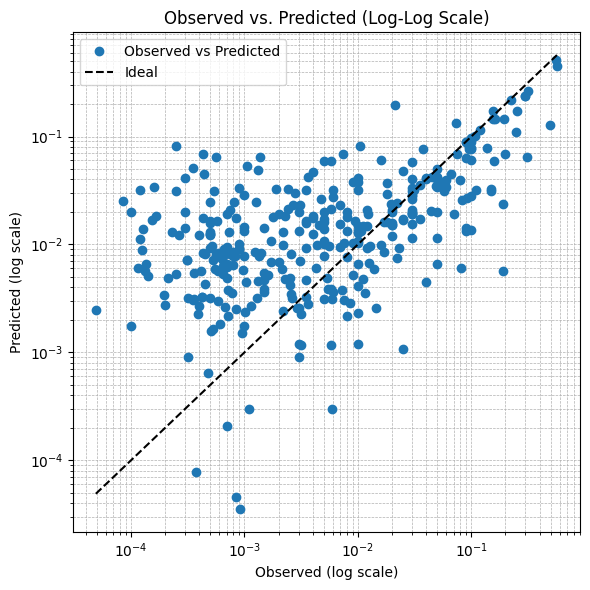

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Model prediction
y_obs = y_re
all_preds_log = best_model.predict(X_re)

all_preds = np.expm1(all_preds_log)

# # Transfer numpy
y_obs = np.ravel(y_obs)
all_preds = np.ravel(all_preds)

#  Plot
plt.figure(figsize=(6, 6))
plt.plot(y_obs, all_preds, 'o', label='Observed vs Predicted')

#Fittness
log_y_obs = np.log10(y_obs )
log_y_pred = np.log10(all_preds)
m, b = np.polyfit(log_y_obs, log_y_pred, 1)

# y = x
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'k--', label='Ideal')

# Label
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Observed (log scale)")
plt.ylabel("Predicted (log scale)")
plt.title("Observed vs. Predicted (Log-Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
r2_score(y_obs, all_preds)

0.6761712697157332

In [ ]:
PredKmax = pd.concat([pd.DataFrame(df_filtered["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","OBS", "PATC"]
PredKmax.to_csv('PATC.csv', encoding = 'utf-8-sig',index=False)

# K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow.keras as keras

dnn_base_model = keras.models.load_model("PATC-0523-11.keras")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvr2scores = []
cvrmsescores = []


for fold, (train_ix, test_ix) in enumerate(kfold.split(X_temp), 1):
    X_train_n, X_test_n = X_temp[train_ix], X_temp[test_ix]
    y_train_n_log, y_test_n_log = y_temp_log[train_ix], y_temp_log[test_ix]

    dnn_model = clone_model(dnn_base_model)
    dnn_model.set_weights(dnn_base_model.get_weights())
    dnn_model.compile(optimizer='Adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience= 32, restore_best_weights=True)

    dnn_model.fit(X_train_n, y_train_n_log,
           validation_data=(X_test_n, y_test_n_log),
           callbacks=[early_stop],
           epochs=512, batch_size=16, verbose=0)

    # Prediction and evaluation
    test_pred_log = dnn_model.predict(X_test_n).flatten()

    test_pred = np.expm1(test_pred_log)
    y_test_n = np.expm1(y_test_n_log)

    r2score = r2_score(y_test_n, test_pred)
    rmse = root_mean_squared_error(y_test_n, test_pred)

    print(f"[Fold {fold}] R²: {r2score:.3f}, RMSE: {rmse:.3f}")

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

# Output
print("\n=== Cross-validation summary ===")
print("The 5-CV R² Score was: %.2f (+/- %.2f)" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-CV RMSE Score was: %.2f (+/- %.2f)" % (np.mean(cvrmsescores), np.std(cvrmsescores)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[Fold 1] R²: 0.862, RMSE: 0.031
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[Fold 2] R²: 0.650, RMSE: 0.051
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[Fold 3] R²: 0.435, RMSE: 0.045
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[Fold 4] R²: 0.696, RMSE: 0.026
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[Fold 5] R²: 0.134, RMSE: 0.030

=== Cross-validation summary ===
The 5-CV R² Score was: 0.56 (+/- 0.25)
The 5-CV RMSE Score was: 0.04 (+/- 0.01)


#Make the prediction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-prediction-1.csv"))
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column
df = pd.DataFrame(Data)

df_ori =df.iloc[0:-2]

q_high=df_ori["PATC"].quantile(0.975)
q_low=df_ori["PATC"].quantile(0.025)
df_filtered=df_ori[(df_ori["PATC"]<q_high)&(df_ori["PATC"]>q_low)]

df_merge = pd.concat([df_filtered, df.iloc[-2:]], axis=0)


df_X = df_merge[["ID","Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_merge[["PATC"]]

test_X = df_X

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)

preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)

y_re = df_y
X_re = preData

In [ ]:
all_preds_log = best_model.predict(X_re.iloc[-2:])
all_preds = np.expm1(all_preds_log)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
all_preds

array([[0.01293436],
       [0.01051452]], dtype=float32)